In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import random
import numpy as np

from tqdm import tqdm
import random
import seaborn as sns

### Utility

Utility functions, spanning from working with epsilon to plotting graphs

In [2]:
def epsilon_greedy_policy(q_values, state, epsilon):
    if np.random.rand() < epsilon:  # With probability epsilon, choose a random action
        action = np.random.randint(len(q_values[state]))
    else:  # With probability (1 - epsilon), choose the action with the highest Q-value for the current state
        action = np.argmax(q_values[state])
    return action

In [3]:
def update_epsilon(epsilon, epsilon_min, epsilon_decay):
    return max(epsilon_min , epsilon_decay * epsilon)

In [4]:
def get_mod_state(env, state):
    _, _, passenger_loc, drop_loc = env.decode(state)
    return 4 * passenger_loc + drop_loc

In [7]:
def plot_average_reward(rewards_history, iterations = 100, title = "average rewards plot"):
    plt.figure(figsize = (10,5))
    avg_rewards = [np.average(rewards_history[i : i + iterations]) for i in range(len(rewards_history) - iterations)]
    plt.plot(avg_rewards,label = 'Model Score')
    plt.plot([8 for i in range(len(avg_rewards))],label = 'Solved line')
    plt.xlabel('Episodes')
    plt.ylabel('score averaged over previous 100 runs')
    plt.title(title)
    plt.legend()

In [8]:
def compare_learning_rewards(rewards_history_list, iterations = 100, title = "Compare rewards"):
    plt.figure(figsize = (20,10))

    for rewards_history, label in rewards_history_list:
        avg_rewards = [np.average(rewards_history[i : i + iterations]) for i in range(len(rewards_history) - iterations)]
        plt.plot(avg_rewards, label = label)

    plt.plot([8 for i in range(len(rewards_history_list[0][0]))], '--', label = 'Solved score line (8)')
    plt.xlabel('Episodes')
    plt.ylabel('score averaged over previous 100 runs')
    plt.title(title)
    plt.legend()

### The Options

- The Option class is defined in a manner that helps encapsulated the options behaviour

- Every Option class also has it's own q-value function, which it will learn.

- The options are only defined on how to reach a particular colored location (R, G, Y, B), so the states of the temporal abstractions need to be only the four directions the car can move in order to reach a location



In [9]:
class Option:
  def __init__(self, env, goal_state, epsilon=0.1, alpha=0.1, gamma=0.99):
    self.env = env
    self.goal_state = goal_state

    # actions to move in each direction
    # states for each location the car can be at
    self.q_value = np.zeros((env.observation_space.n//20, env.action_space.n - 2))
    
    self.epsilon = epsilon
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.99
    self.alpha = alpha
    self.gamma = gamma

  def is_done(self, state):
    x, y, _, _ = self.env.decode(state)
    return x == self.goal_state[0] and y == self.goal_state[1]
  
  def _update_epsilon(self):
    self.epsilon = update_epsilon(self.epsilon, self.epsilon_min, self.epsilon_decay)

  def update_policy(self, state, action, reward, next_state):
    x, y, _, _ = self.env.decode(state)
    nx, ny, _, _ = self.env.decode(next_state)
    self.q_value[5*x+y, action] += self.alpha * (reward + self.gamma * np.max(self.q_value[5*nx+ny, :]) - self.q_value[5*x+y, action])

  def select_action(self, state):
    if self.is_done(state):
      # Once the option is done, we do not pick any further actions within the option
      return (None, True)
    else:
      x, y, _, _ = self.env.decode(state)
      option_action = epsilon_greedy_policy(self.q_value, 5*x+y, epsilon=self.epsilon)
      self._update_epsilon()
      return (option_action, False)

### The Environment

In [10]:
env = gym.make('Taxi-v3', render_mode="rgb_array")

### Q-Learning to learn Option Policy, when the Option selection in pre-determined

In [14]:
options_init = {ind: Option(env, loc) for ind, loc in enumerate(env.unwrapped.locs)}
episodes = 2500
rewards_history_p1 = []
gamma = 0.99
for _ in tqdm(range(episodes)):
    state = env.reset()[0]
    done = False
    episode_reward = 0

    # While episode is not over
    while not done:
        _, _, passenger_loc, drop_loc = env.decode(state)

        # Go to the passenger and pick up
        reward_bar = 0
        passenger_found = False
        while not passenger_found and not done and passenger_loc < 4:
            # Select action using the option
            action, passenger_found = options_init.get(passenger_loc).select_action(state)

            if action is None and passenger_found:
                action = 4 # pick up the passenger

            next_state, reward, done, _, _ = env.step(action)

            # Calculate the accumulated reward for the option
            reward_bar = gamma * reward_bar + reward
            episode_reward += reward

            # update option policy
            if action < 4:
                options_init.get(passenger_loc).update_policy(state, action, reward_bar, next_state)
            state = next_state

        reward_bar = 0
        trip_complete = False
        while not trip_complete and not done:
            # Select action using the option
            action, trip_complete = options_init.get(drop_loc).select_action(state)

            if action is None and trip_complete:
                action = 5 # drop the passenger

            next_state, reward, done, _, _ = env.step(action)

            # Calculate the accumulated reward for the option
            reward_bar = gamma * reward_bar + reward
            episode_reward += reward

            # update option policy
            if action < 4:
                options_init.get(drop_loc).update_policy(state, action, reward_bar, next_state)

            state = next_state

    rewards_history_p1.append(episode_reward)

  0%|                                                                                                                 | 0/2500 [00:00<?, ?it/s]/Users/arjunramesh/.local/share/virtualenvs/RL_2024_PA_3-5EEPQmDE/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.decode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.decode` for environment variables or `env.get_wrapper_attr('decode')` that will search the reminding wrappers.
  logger.warn(
100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:01<00:00, 1501.20it/s]


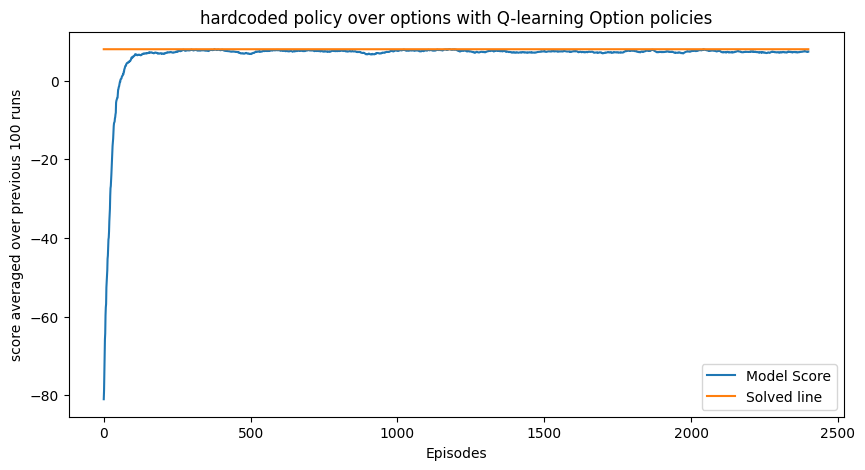

In [15]:
plot_average_reward(rewards_history_p1, title='hardcoded policy over options with Q-learning Option policies')

---

In [13]:
import copy

In [16]:
# We use the option policies learned with pre-determined option sequence, to help with the learning process
options = copy.deepcopy(options_init)


smdp_state_count = 500 # we are going to consider states as a combination of passenger and driver location
smdp_action_count = 10 # 6 options + 2 primitive actions for pick-up and drop-off

smdp_q_vlaues = np.zeros((smdp_state_count, smdp_action_count))
update_freq = np.zeros((smdp_state_count, smdp_action_count))

smdp_epsilon = 0.1
smdp_epsilon_min = 0.01
smdp_epsilon_decay = 0.99

alpha = 0.1
gamma = 0.99

In [17]:
episodes = 2500
rewards_history_p2 = []
gamma = 0.99
for _ in tqdm(range(episodes)):
    state = env.reset()[0]
    done = False
    episode_reward = 0

    # While episode is not over
    while not done:
        x, y, passenger_loc, drop_loc = env.decode(state)

        action = epsilon_greedy_policy(smdp_q_vlaues, state, smdp_epsilon)
        update_epsilon(smdp_epsilon, smdp_epsilon_min, smdp_epsilon_decay)

        # If primitive action is selected
        if action < 6:
            # Perform regular Q-Learning update for state-action pair
            next_state, reward, done, _, _ = env.step(action)
            smdp_q_vlaues[state, action] += alpha * (reward + gamma * np.max(smdp_q_vlaues[next_state]) - smdp_q_vlaues[state, action])
            update_freq[state, action] += 1

            state = next_state
        else:
            option_index = action - env.action_space.n
            option = options.get(option_index)

            reward_bar = 0
            option_done = False
            while not done:
                x, y, _, _ = env.decode(state)
                option_action, option_done = option.select_action(state)
                if option_done:
                    break

                next_state, reward, done, _, _ = env.step(option_action)

                episode_reward += reward
                reward_bar = gamma * reward_bar + reward
                
                option.update_policy(state, option_action, reward, next_state)
            
                smdp_q_vlaues[state, action] += alpha * (reward_bar + gamma * np.max(smdp_q_vlaues[next_state]) - smdp_q_vlaues[state, action])
                update_freq[state, action] += 1

                state = next_state

    rewards_history_p2.append(episode_reward)

  0%|                                                                                                                 | 0/2500 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:51<00:00, 48.35it/s]


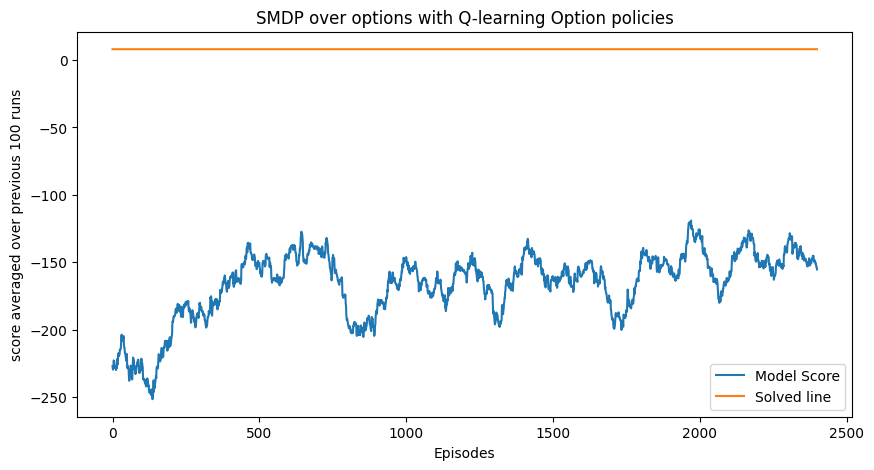

In [18]:
plot_average_reward(rewards_history_p2, title='SMDP over options with Q-learning Option policies')

---

In [19]:
# We use the option policies learned with pre-determined option sequence, to help with the learning process
options = copy.deepcopy(options_init)

ioql_state_count = 500 # we are going to consider states as a combination of passenger and driver location
ioql_action_count = 10 # 6 options + 2 primitive actions for pick-up and drop-off

ioql_q_vlaues = np.zeros((ioql_state_count, ioql_action_count))
ioql_update_freq = np.zeros((ioql_state_count, ioql_action_count))

ioql_epsilon = 0.1
ioql_epsilon_min = 0.01
ioql_epsilon_decay = 0.99

alpha = 0.1
gamma = 0.99

In [23]:
episodes = 2500
rewards_history_p3 = []
gamma = 0.99
for _ in tqdm(range(episodes)):
    state = env.reset()[0]
    done = False
    episode_reward = 0

    # While episode is not over
    while not done:
        x, y, passenger_loc, drop_loc = env.decode(state)

        action = epsilon_greedy_policy(ioql_q_vlaues, state, ioql_epsilon)
        update_epsilon(ioql_epsilon, ioql_epsilon_min, ioql_epsilon_decay)

        # If primitive action is selected
        if action < 6:
            # Perform regular Q-Learning update for state-action pair
            next_state, reward, done, _, _ = env.step(action)
            ioql_q_vlaues[state, action] += alpha * (reward + gamma * np.max(ioql_q_vlaues[next_state]) - ioql_q_vlaues[state, action])
            ioql_update_freq[state, action] += 1

            state = next_state
        else:
            option_index = action -  env.action_space.n
            option = options.get(option_index)
            # update_epsilon(smdp_epsilon, smdp_epsilon_min, smdp_epsilon_decay)
            reward_bar = 0
            option_done = False
            prev_state = state
            option_moves = 0
            while not done:
                x, y, _, _ = env.decode(state)
                option_action, option_done = option.select_action(state)
                if option_done:
                    break

                next_state, reward, done, _, _ = env.step(option_action)

                episode_reward += reward
                reward_bar = gamma * reward_bar + reward
                option_moves += 1

                option.update_policy(state, option_action, reward, next_state)

                for opt_index, temp_option in options.items():
                    option_action_o, option_done_o = temp_option.select_action(state)
                    if option_action_o == option_action:
                        if option_done_o:
                            ioql_q_vlaues[state, 6 + opt_index] += alpha*(reward + gamma * np.max(ioql_q_vlaues[next_state, :]) - ioql_q_vlaues[state, 6 + opt_index])
                        else:
                            ioql_q_vlaues[state, 6 + opt_index] += alpha*(reward + gamma * ioql_q_vlaues[next_state, 6 + opt_index] - ioql_q_vlaues[state, 6 + opt_index]) 

                        ioql_update_freq[state, 6 + opt_index] += 1

                state = next_state

    rewards_history_p3.append(episode_reward)

  0%|                                                                                                                 | 0/2500 [00:00<?, ?it/s]/Users/arjunramesh/.local/share/virtualenvs/RL_2024_PA_3-5EEPQmDE/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.decode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.decode` for environment variables or `env.get_wrapper_attr('decode')` that will search the reminding wrappers.
  logger.warn(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:55<00:00, 44.78it/s]


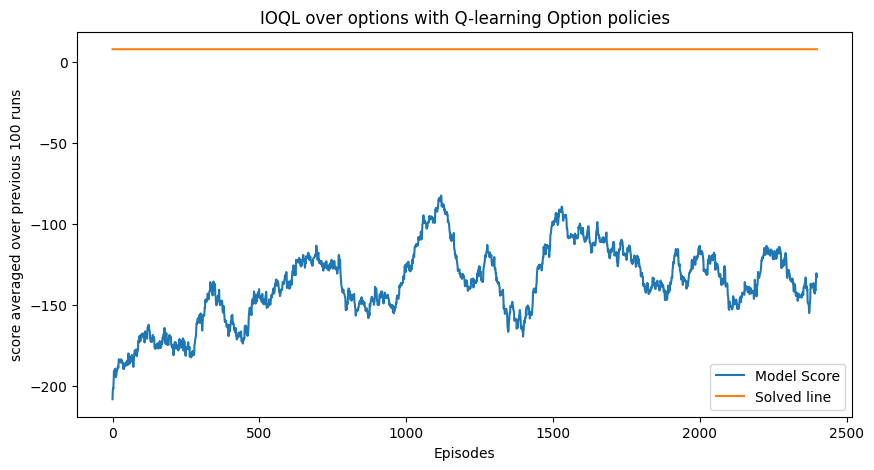

In [21]:
plot_average_reward(rewards_history_p3, title='IOQL over options with Q-learning Option policies')

----

### Compare Algorithms

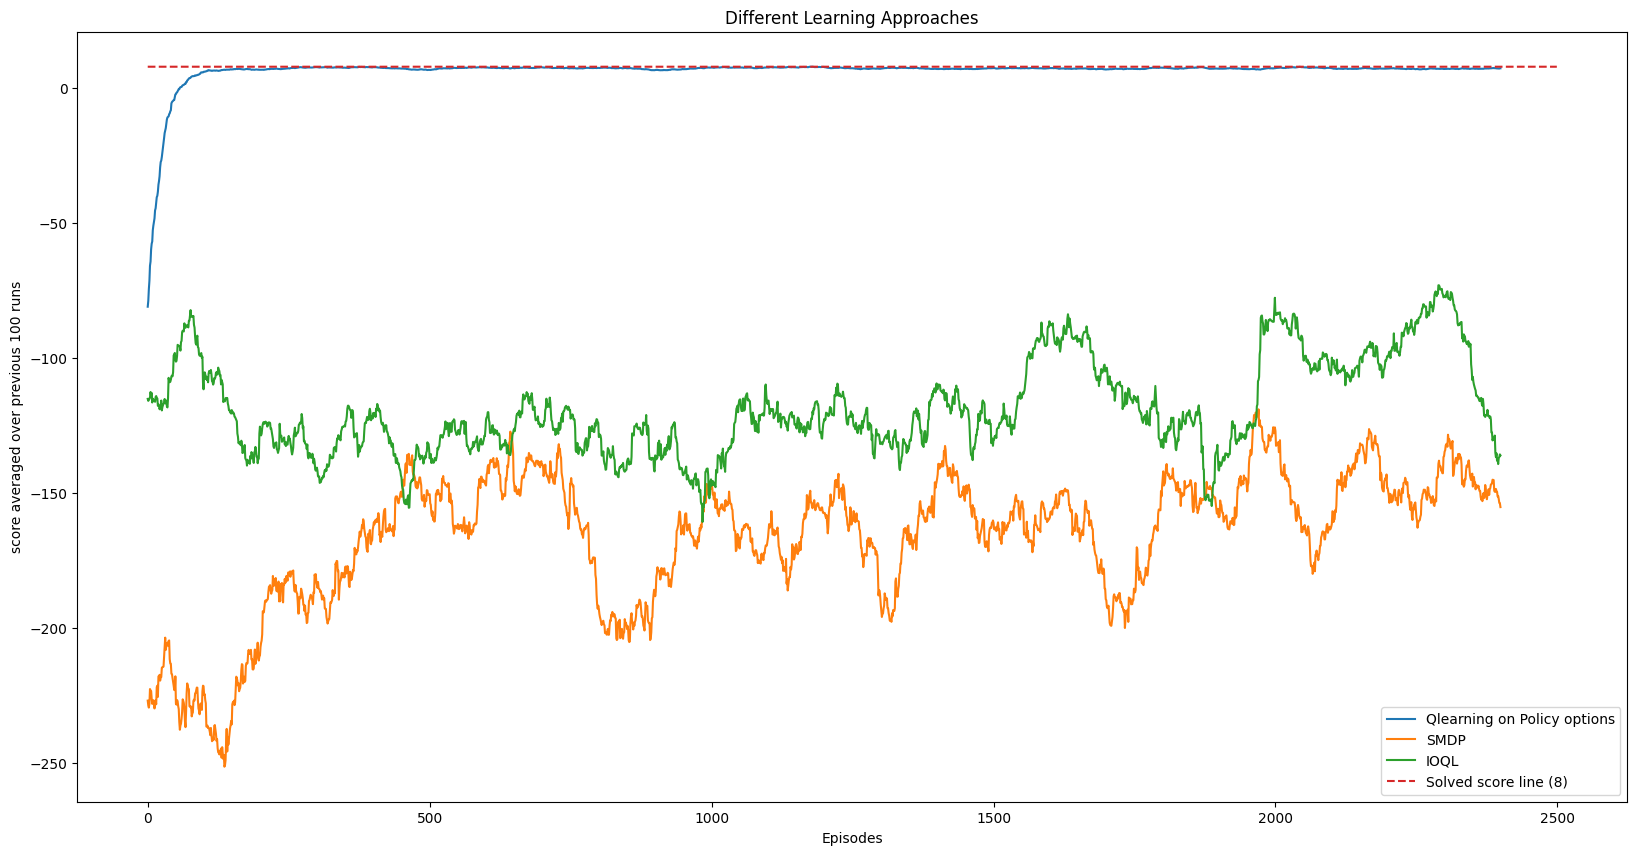

In [24]:
rewards_history_list = [
    (rewards_history_p1, 'Qlearning on Policy options'),
    (rewards_history_p2, 'SMDP'),
    (rewards_history_p3, 'IOQL')
]

compare_learning_rewards(rewards_history_list, title='Different Learning Approaches')